In [1]:
#ways to deal with underfitting
#more epochs: allow the model to train for longer
#larger learning rate: allow the model to make larger adjustments
#increase complexity: more complex model can fit to the training data more precisely

In [2]:
import torch
import torchvision
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'gpu'
device

'cuda'

In [8]:
import requests
import zipfile
from pathlib import Path

data_path = Path('data/')
img_path = data_path / 'pizza_steak_sushi_20_percent'

if img_path.is_dir():
  print(f'already exists')
else:
  print('creating dir')
  img_path.mkdir(parents = True, exist_ok = True)

  with open(data_path / 'pizza_steak_sushi_20_percent.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip')
    print('downloading')
    f.write(request.content)

  with zipfile.ZipFile(data_path / 'pizza_steak_sushi_20_percent.zip', 'r') as zip_ref:
    print('unzipping')
    zip_ref.extractall(img_path)

creating dir
downloading
unzipping


In [9]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'there are {len(dirnames)} directories, {len(filenames)} images in {dirpath}')

In [10]:
walk_through_dir(img_path)

there are 2 directories, 0 images in data/pizza_steak_sushi_20_percent
there are 3 directories, 0 images in data/pizza_steak_sushi_20_percent/test
there are 0 directories, 58 images in data/pizza_steak_sushi_20_percent/test/steak
there are 0 directories, 46 images in data/pizza_steak_sushi_20_percent/test/pizza
there are 0 directories, 46 images in data/pizza_steak_sushi_20_percent/test/sushi
there are 3 directories, 0 images in data/pizza_steak_sushi_20_percent/train
there are 0 directories, 146 images in data/pizza_steak_sushi_20_percent/train/steak
there are 0 directories, 154 images in data/pizza_steak_sushi_20_percent/train/pizza
there are 0 directories, 150 images in data/pizza_steak_sushi_20_percent/train/sushi


In [11]:
train_dir = img_path / 'train'
test_dir = img_path/ 'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [12]:
trans = transforms.Compose([
    transforms.Resize(size= (64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

In [13]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform = trans,
                                  target_transform=None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = trans)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi_20_percent/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data/pizza_steak_sushi_20_percent/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
NUM_WORKERS = os.cpu_count()
train_DL = DataLoader(dataset= train_data,
                      batch_size = 32,
                      num_workers = NUM_WORKERS,
                      shuffle = True)

test_DL = DataLoader(dataset = test_data,
                     batch_size = 32,
                     num_workers = NUM_WORKERS,
                     shuffle = False)

In [25]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size = 3,
                  stride = 1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(hidden_units,hidden_units, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features = output_shape)
    )

  def forward(self, x: torch.Tensor):
    return self.classifier(self.conv_block2(self.conv_block1(x)))

In [26]:
torch.manual_seed(199)
model_0 = TinyVGG(3, 10, len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [18]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(pred, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item()/len(pred)

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [19]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  model.eval()
  test_loss, test_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    test_pred = model(X)
    loss = loss_fn(test_pred, y)
    test_loss += loss.item()

    test_pred_class = torch.argmax(torch.softmax(test_pred, dim = 1), dim = 1)
    test_acc += (test_pred_class == y).sum().item()/len(test_pred)

  test_loss /= len(dataloader)
  test_acc/= len(dataloader)
  return test_loss, test_acc

In [23]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int):
  results = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn)
    print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [30]:
torch.manual_seed(199)
torch.cuda.manual_seed(199)

EPOCHS = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)

from timeit import default_timer as timer
start_time = timer()
model_0_results_20_epochs = train(model_0, train_DL, test_DL, loss_fn, optimizer, EPOCHS)
end_time = timer()

print(f'total train time: {end_time - start_time:.3f} seconds')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7677 | train_acc: 0.6271 | test_loss: 0.8972 | test_acc: 0.5523
Epoch: 2 | train_loss: 0.7243 | train_acc: 0.6958 | test_loss: 0.8506 | test_acc: 0.6062
Epoch: 3 | train_loss: 0.7078 | train_acc: 0.6958 | test_loss: 0.9133 | test_acc: 0.6142
Epoch: 4 | train_loss: 0.7105 | train_acc: 0.6875 | test_loss: 0.8574 | test_acc: 0.5966
Epoch: 5 | train_loss: 0.6943 | train_acc: 0.6813 | test_loss: 0.8782 | test_acc: 0.6136
Epoch: 6 | train_loss: 0.7587 | train_acc: 0.6562 | test_loss: 0.9270 | test_acc: 0.5693
Epoch: 7 | train_loss: 0.6995 | train_acc: 0.7229 | test_loss: 0.8532 | test_acc: 0.6528
Epoch: 8 | train_loss: 0.6454 | train_acc: 0.7521 | test_loss: 0.8748 | test_acc: 0.6074
Epoch: 9 | train_loss: 0.6348 | train_acc: 0.7417 | test_loss: 0.8908 | test_acc: 0.6261
Epoch: 10 | train_loss: 0.6114 | train_acc: 0.7333 | test_loss: 0.8573 | test_acc: 0.6534
Epoch: 11 | train_loss: 0.6123 | train_acc: 0.7125 | test_loss: 0.9002 | test_acc: 0.6182
Epoch: 12 | train_l

In [32]:
torch.manual_seed(199)
torch.cuda.manual_seed(199)
model_1 = TinyVGG(3, 20, len(class_names)).to(device) #double the hidden layer amount
optimizer_1 = torch.optim.Adam(params = model_1.parameters(), lr = 0.001)

EPOCHS = 20

start_time = timer()
model_1_results_20_epochs = train(model_1, train_DL, test_DL, loss_fn, optimizer_1, EPOCHS)
end_time = timer()

print(f'trained in {end_time- start_time:.3f} seconds')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1043 | train_acc: 0.2917 | test_loss: 1.0970 | test_acc: 0.4295
Epoch: 2 | train_loss: 1.0772 | train_acc: 0.4729 | test_loss: 1.1172 | test_acc: 0.2938
Epoch: 3 | train_loss: 1.0917 | train_acc: 0.3542 | test_loss: 1.0489 | test_acc: 0.4670
Epoch: 4 | train_loss: 0.9909 | train_acc: 0.5563 | test_loss: 0.9088 | test_acc: 0.5432
Epoch: 5 | train_loss: 0.9203 | train_acc: 0.5563 | test_loss: 0.9342 | test_acc: 0.4750
Epoch: 6 | train_loss: 0.8991 | train_acc: 0.5563 | test_loss: 0.9173 | test_acc: 0.5608
Epoch: 7 | train_loss: 0.9300 | train_acc: 0.5375 | test_loss: 0.8951 | test_acc: 0.5972
Epoch: 8 | train_loss: 0.8542 | train_acc: 0.6521 | test_loss: 0.9003 | test_acc: 0.5273
Epoch: 9 | train_loss: 0.8827 | train_acc: 0.6104 | test_loss: 0.9031 | test_acc: 0.5949
Epoch: 10 | train_loss: 0.8209 | train_acc: 0.6604 | test_loss: 0.8838 | test_acc: 0.5994
Epoch: 11 | train_loss: 0.8635 | train_acc: 0.6458 | test_loss: 0.9306 | test_acc: 0.5710
Epoch: 12 | train_l

In [35]:
from typing import Dict, List
import matplotlib.pyplot as plt

def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results['train_loss']
  test_loss = results['test_loss']
  acc = results['train_acc']
  test_acc = results['test_acc']

  epochs = range(len(loss))

  plt.figure(figsize = (15, 7))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label = 'train loss')
  plt.plot(epochs, test_loss, label = 'test loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label='train_accuracy')
  plt.plot(epochs, test_acc, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

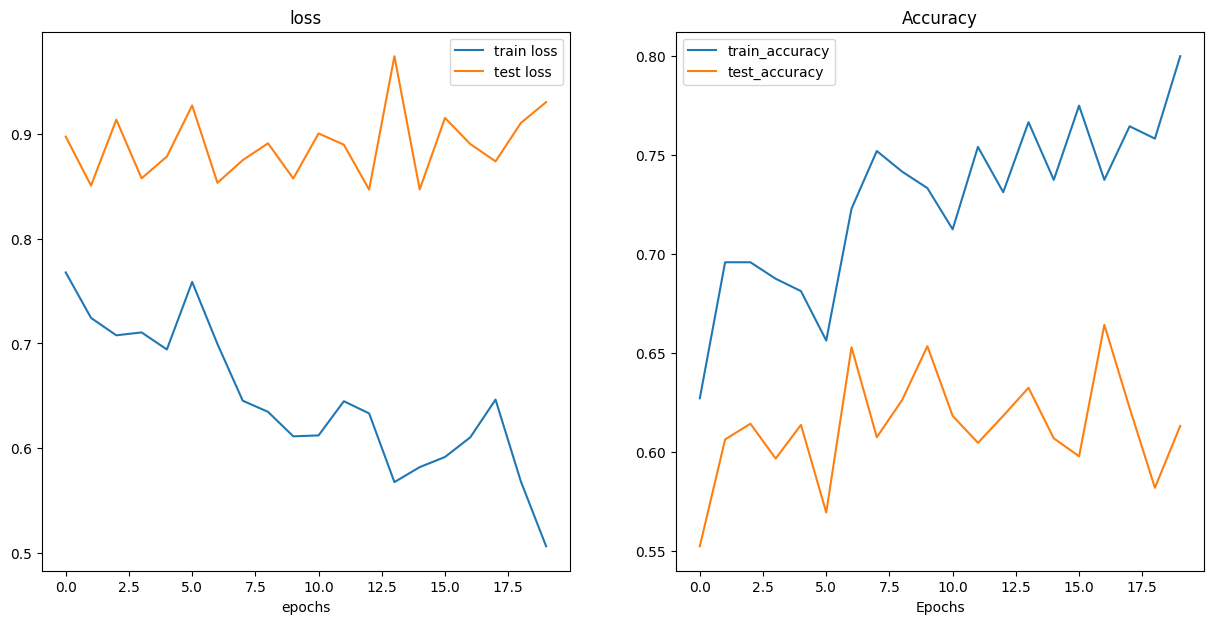

In [36]:
plot_loss_curves(model_0_results_20_epochs)

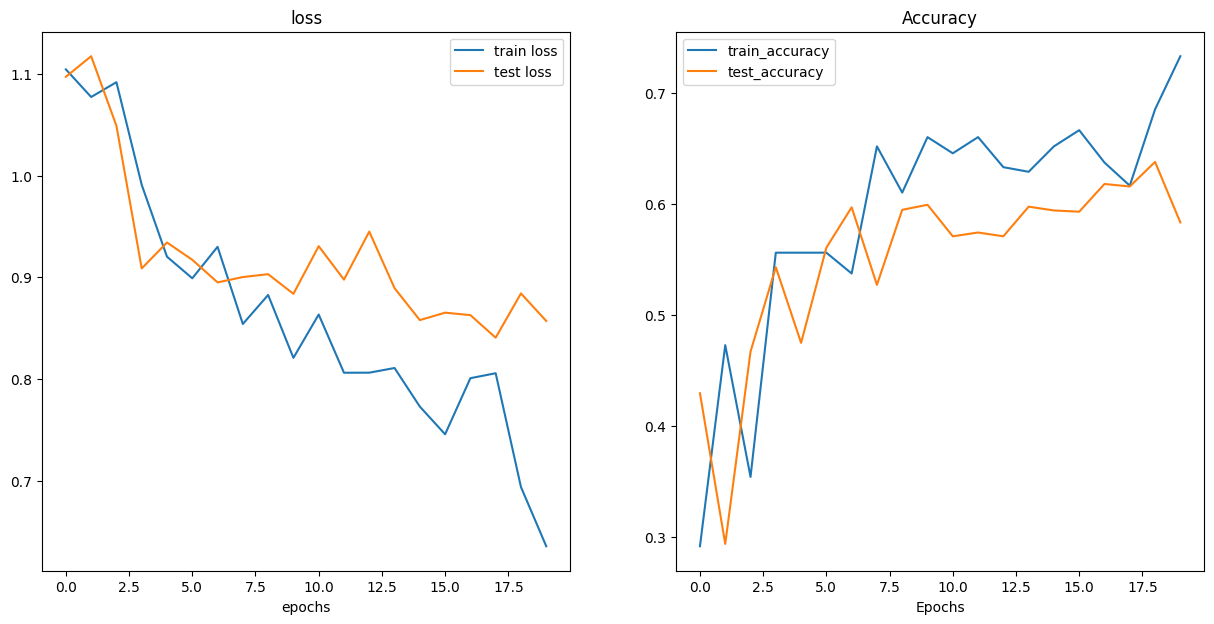

In [37]:
plot_loss_curves(model_1_results_20_epochs)

In [38]:
#models still not performing great, but looks like more complex and more epochs is improving things

In [40]:
#custom image
cust_img_path = data_path / '04-pizza-dad.jpeg'

if not cust_img_path.is_file():
  with open(cust_img_path, 'wb') as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print('downloading')
    f.write(request.content)
else:
  print('already exists')

downloading


In [43]:
custom_image = (torchvision.io.read_image(str(cust_img_path)).type(torch.float32) /255)

In [44]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

custom_image = custom_image_transform(custom_image)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [59]:
#prediction:
model_1.eval()
with torch.inference_mode():
  pred = model_1(custom_image.unsqueeze(dim = 0).to(device))

In [60]:
print(f'pred logits: {pred}')
pred_probs = torch.softmax(pred, dim = 1)
print(f'pred probs: {pred_probs}')
pred_label = torch.argmax(pred_probs, dim = 1)
print(f'pred label: {pred_label}')

pred logits: tensor([[-0.4458, -0.9291, -0.3119]], device='cuda:0')
pred probs: tensor([[0.3623, 0.2235, 0.4142]], device='cuda:0')
pred label: tensor([2], device='cuda:0')


In [61]:
# Find the predicted label
custom_image_pred_class = class_names[pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'sushi'

In [62]:
#didn't guess correctly. will try one more complex model

In [64]:
torch.manual_seed(199)
torch.cuda.manual_seed(199)
model_2 = TinyVGG(3, 30, len(class_names)).to(device)

optimizer_2 = torch.optim.Adam(params = model_2.parameters(), lr = 0.001)

EPOCHS = 30

start = timer()
model_2_results_30_epochs = train(model_2, train_DL, test_DL, loss_fn, optimizer_2, EPOCHS)
end = timer()

print(f'train time is {end - start} seconds')

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1075 | train_acc: 0.3729 | test_loss: 1.0989 | test_acc: 0.2875
Epoch: 2 | train_loss: 1.0989 | train_acc: 0.3167 | test_loss: 1.0930 | test_acc: 0.4000
Epoch: 3 | train_loss: 1.0594 | train_acc: 0.4792 | test_loss: 1.0564 | test_acc: 0.3812
Epoch: 4 | train_loss: 1.0182 | train_acc: 0.4833 | test_loss: 0.9764 | test_acc: 0.4670
Epoch: 5 | train_loss: 0.9421 | train_acc: 0.5146 | test_loss: 0.9122 | test_acc: 0.5920
Epoch: 6 | train_loss: 0.8586 | train_acc: 0.5979 | test_loss: 0.9343 | test_acc: 0.5898
Epoch: 7 | train_loss: 0.8631 | train_acc: 0.6125 | test_loss: 0.8967 | test_acc: 0.5375
Epoch: 8 | train_loss: 0.8278 | train_acc: 0.6312 | test_loss: 0.9195 | test_acc: 0.5602
Epoch: 9 | train_loss: 0.8152 | train_acc: 0.5958 | test_loss: 0.8871 | test_acc: 0.6114
Epoch: 10 | train_loss: 0.8409 | train_acc: 0.6292 | test_loss: 0.8718 | test_acc: 0.5818
Epoch: 11 | train_loss: 0.7993 | train_acc: 0.6417 | test_loss: 0.8686 | test_acc: 0.5847
Epoch: 12 | train_l

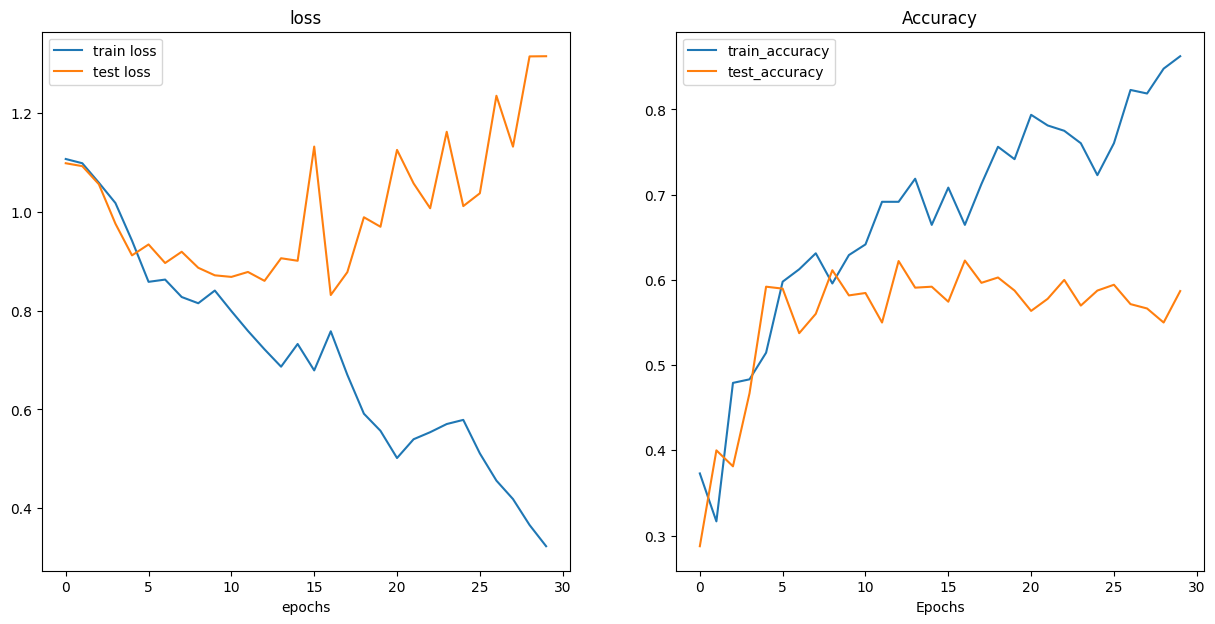

In [65]:
plot_loss_curves(model_2_results_30_epochs)

In [67]:
'''
now it is clear that increasing the epochs and complexity has reached a wall in terms of
performance improvement. Other steps, such as using more training data or increasing trivial
augmentation, will be necessary to improve performance.
'''

'\nnow it is clear that increasing the epochs and complexity has reached a wall in terms of\nperformance improvement. Other steps, such as using more training data or increasing trivial\naugmentation, will be necessary to improve performance.\n'

In [69]:
model_2.eval()
with torch.inference_mode():
  pred2 = model_2(custom_image.unsqueeze(dim = 0).to(device))

In [70]:
print(f'pred logits: {pred2}')
pred_probs2 = torch.softmax(pred2, dim = 1)
print(f'pred probs: {pred_probs2}')
pred_label2 = torch.argmax(pred_probs2, dim = 1)
print(f'pred label: {pred_label2}')

pred logits: tensor([[ 0.4712, -3.1364, -2.0419]], device='cuda:0')
pred probs: tensor([[0.9024, 0.0245, 0.0731]], device='cuda:0')
pred label: tensor([0], device='cuda:0')


In [71]:
# Find the predicted label
custom_image_pred_class2 = class_names[pred_label2.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class2

'pizza'

In [72]:
#correct prediction!